# Proyecto 03 - Sistemas de Recomendación - Ivan Aldana

Link al project en GitHub:
https://github.com/ivanaldana/acamica-projects


## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
import warnings 
warnings.filterwarnings('ignore')

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
# dado que ya estamos en una fase mas avanzada, tomaremos todos los datos, o sea n = 1
n = 1
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


convertimos el arreglo en dataframe

In [4]:
data_reviews = pd.DataFrame(data_reviews)

# Analisis de Datos

In [5]:
#data_reviews.loc[data_reviews.hours==28164.000000]
print('El dataset contiene ',data_reviews.shape[0],'filas y ',data_reviews.shape[1],'columnas')

El dataset contiene  7793069 filas y  12 columnas


In [6]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


Analisis de valores nulos

In [7]:
#calculo de cada columna faltante
print('Cantidad de Nulls por cada columna')
null_df = pd.DataFrame(data_reviews.isna().sum(),columns=['Faltantes'])
null_df['Columna'] = null_df.index
null_df.reset_index(drop=True, inplace=True)
null_df.loc[null_df['Faltantes']>0,['Columna','Faltantes']].head(200)

Cantidad de Nulls por cada columna


,Columna,Faltantes
1,hours,26537
2,products,14961
9,found_funny,6592313
10,compensation,7647446
11,user_id,4616846


Dado que en steam el valor real de usuario unico es **user_id**, no asi **username**, el cual puede repetirse en distintos usuarios porque es solo un nomenclador,
vamos a priorizar conservar este distintivo en el dataset, sobrescribiendo este valor en la columna **username** para aquellos valores no nulos de **user_id**. Se puede observar que la columna **username** no posee valores nulos, intentaremos usar los valores de esta como segunda opcion de clave.

In [8]:
#Paso los user_id no nulos a la columna username para poder trabajar mas comodamente
data_reviews.username.loc[data_reviews.user_id.isna()==False] = "uid:"+data_reviews.user_id.loc[data_reviews.user_id.isna()==False]

In [9]:
#Me quedo con las columnas que mas me sirven
data_reviews_filtrado = data_reviews[["username","hours","product_id","text"]]
#Elimino los datos duplicados
data_reviews_filtrado = data_reviews_filtrado.drop_duplicates()

In [10]:
print('cantidad de filas luego de la primer limpieza:',data_reviews_filtrado.shape[0])

cantidad de filas luego de la primer limpieza: 6961282


In [11]:
#Guardo el dataframe para poder abrirlo en pasos posteriores, sin la necesidad de hacer el load y parse del archivo gz
data_reviews_filtrado.to_csv('data_reviews_filtrado.csv', index= False)

# CheckPoint 1

Volvemos a importar todas las librerias que utilizaremos, el paso anterior de analisis y pre-cargado queda cerrado.

In [12]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
import warnings 
warnings.filterwarnings('ignore')

In [13]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [14]:
data_reviews_filtrado = pd.read_csv('data_reviews_filtrado.csv')

corroboramos si efectivamente esta combinacion esta duplicada.

**Games**

In [15]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [16]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [17]:
data_games[data_games.id == '224600']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
28926,"Trion Worlds, Inc.","[Action, Free to Play, Massively Multiplayer, ...",Defiance,Defiance,http://store.steampowered.com/app/224600/Defia...,2014-06-04,"[Free to Play, Action, Open World, Massively M...",NaN,http://steamcommunity.com/app/224600/reviews/?...,"[Multi-player, MMO, Co-op, Steam Trading Cards...",Free to Play,False,224600,"Trion Worlds, Inc.",Mostly Positive,64


**Exploracion de datos**

a) Explora la fuente de datos: ¿Que representa el dataset? ¿Hay informacion sobre las columnas?

En este proyecto hay dos datasets, el primero "data_reviews", contiene la informacion de millones de
reseñas a juegos de Steam y que fueron hechas por los mismos jugadores


* **username**: es el nombre/alias de la persona que esta haciendo la review.
* **hours**: indica la cantidad de horas que tiene jugadas al juego en cuestion.
* **products**: indica la cantidad de juegos que tiene el usuario.

* **product_id**: almacena un numero UNICO el cual representa los distintos juegos que se encuentran en 
steam.

* **page_order**:

* **date**: indica la fecha de publicacion de la reseña.

* **text**: indica el texto que escribio el usuario.

* **early_access**: en los juegos, que se encuentre en "early access" significa que se puede jugar/probar el
juego antes de que haya salido oficialmente, esto sirve generalmente para buscar fallos.

* **page**: indica el numero de pagina donde se encuentra la reseña

* **found_funny**: indica si le gusto o no el juego.

* **compensation**: indica si pago el producto o lo recibio gratis.

* **user_id**: es lo mismo que el "product_id" solo que para los usuarios, basicamente es un numero identificador para los usuarios.Ya que el "username" se puede cambiar en cualquier momento y pueden existir nombres repetidos se utiliza el user_id para identificar a cada jugador.


Luego tenemos el otro dataset llamado "data_game", contiene la informacion de cada juego, si es popular y si es pago o gratuito, ademas tambien contiene los generos del juego. por ejemplo accion, multijugador, etc.

* **publisher**: indica la distribuidora que esta publicitando el juego.
* **genres**: indica los generos del juego.
* **app_name**: indica el nombre del juego.
* **title**: indica el titulo del juego.
* **url**: indica la pagina en donde se encuentra en steam.
* **release_date**: indica la fecha de salida del juego.
* **tags**: indica los tags del juego, esto es para una mejor busqueda a la hora de publicitarse.
* **discount_price**: indica el precio que tiene en descuento.
* **reviews_url**: indica la pagina donde se encuentran las reseñas del juego.
* **specs**: indica los requisitos para poder jugar al juego.
* **price**: indica el precio del juego.
* **early_access**: indica si se encuentra en early access o no.
* **id**: indica el codigo del juego (es decir el product_id)
* **developer**: indica quien desarrollo el juego.
* **sentiment**: indica si el juego es gustado o no.
* **metascore**: esto es un puntaje que otorga "metacritic" e indica que tan bueno es el juego y va de 0-100.

Verificacion de que el dataset cumple con las premisas del modelo, o sea valores unicos para la combinacion de **username+product_id**

In [18]:
data_reviews_filtrado.groupby(["username","product_id"]).count().sort_values('hours',ascending=False).head()


hours  text
username product_id             
123      346110        181   181
         252490         27    27
         433850         18    18
Red      440            18    18
Jack     440            17    17

corroboramos si efectivamente esta combinacion esta duplicada.

In [19]:
data_reviews_filtrado.loc[(data_reviews_filtrado.username=="123")&(data_reviews_filtrado.product_id==346110)]

,username,hours,product_id,text
4641031,123,4838.5,346110,Bans for days.
4646124,123,1926.6,346110,10/10
4658369,123,2867.9,346110,Takes over your life and will give you no free...
4659332,123,2696.6,346110,This game is like crack. You won't be able to ...
4661365,123,413.7,346110,I'm playing this game for a couple of weeks no...
...,...,...,...,...
4781451,123,1406.0,346110,Hello all So I made a base and it was great I ...
4781610,123,285.2,346110,Official Servers are more than 2 months with D...
4781720,123,3064.9,346110,Love it
4781752,123,6522.7,346110,3800 Hours played nearly and I still love this...


De todas las combinaciones duplicadas, nos quedaremos solamente con el primer registro

In [20]:
print('Cantidad de registros antes:  ',data_reviews_filtrado.shape[0])
data_reviews_filtrado = data_reviews_filtrado.groupby(["product_id","username"]).first()
data_reviews_filtrado = data_reviews_filtrado.reset_index()
print('Cantidad de registros despues:',data_reviews_filtrado.shape[0])

Cantidad de registros antes:   6961282
Cantidad de registros despues: 6929816


Analizamos los valores Nulos

In [21]:
#calculo de cada columna faltante
print('Cantidad de Nulls por cada columna')
null_df = pd.DataFrame(data_reviews_filtrado.isna().sum(),columns=['Faltantes'])
null_df['Columna'] = null_df.index
null_df.reset_index(drop=True, inplace=True)
null_df.loc[null_df['Faltantes']>0,['Columna','Faltantes']].head(200)

Cantidad de Nulls por cada columna


,Columna,Faltantes
2,hours,25825
3,text,16041


Como solamente tenemos valores nulos en **hours**, lo vamos a rellenar con 0.
El valor de **text** por ahora lo dejamos como esta, ya que en la logica de procesamiento por ahora solo vamos a considerar el atributo **hours** para el modelo.

In [22]:
data_reviews_filtrado["hours"].fillna(0,inplace=True)

In [23]:
#Guardo el dataframe para poder abrirlo mas facilmente
data_reviews_filtrado.to_csv('data_reviews_filtrado_unique.csv', index= False)

# CheckPoint 2

En esta etapa vamos a realizar los siguientes pasos:

**1-** Obtenemos de nuestro Dataset la lista unica de Productos(Juegos)

**2-** Como la idea es obtener un catalogador de puntaje de [0..4], obtendremos los percentiles de cada producto
y lo [20,40,60,80,100]

**3-** Con lo obtenido en el punto anterior, asignamos una nueva columnas a nuestro dataset de username/product_id

Volvemos a importar las librerias interesadas

In [24]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
import warnings 
warnings.filterwarnings('ignore')

In [25]:
data_reviews_filtrado_unique = pd.read_csv('data_reviews_filtrado_unique.csv')

In [26]:
#obtenemos la lista de productos con la que vamos a trabajar
productos_array = data_reviews_filtrado_unique.product_id.unique()
productos_array.sort()

**Induccion de percentiles por producto**

In [27]:
bins = []

for product_id in tqdm(productos_array):
    
    prs=np.percentile(data_reviews_filtrado_unique.loc[data_reviews_filtrado_unique.product_id==product_id].hours, [20,40,60,80,100])    
    
    ###como el sistema es duro y requiere al menos que el producto tenga 5 scores posibles,
    ###se se elininan aquellos que no cumplen con esta premisa
    if len(np.unique(prs))<5:
        continue
    
    pr20 =prs[0]
    pr40 =prs[1]
    pr60 =prs[2]
    pr80 =prs[3]
    pr100=prs[4]
    
    bins.append([product_id,pr20,pr40,pr60,pr80,pr100])
        
df_distribucion = pd.DataFrame(bins,columns=["product_id","20","40","60","80","100"])

100%|██████████| 15474/15474 [01:32<00:00, 167.71it/s]


Cruzamos ambos dataset de data_reviews_score  y df_distribucion para tener todo en dataset unico y evitar ejecuciones ciclicas

In [28]:
data_reviews_score = pd.merge(data_reviews_filtrado_unique, df_distribucion, on="product_id")
data_reviews_score["score"] = np.nan

**Induccion del Score a partir de los percentiles**

In [29]:
data_reviews_score.score.loc[(data_reviews_score.hours<=data_reviews_score["20"])  & (data_reviews_score.score.isna())] = 1
data_reviews_score.score.loc[(data_reviews_score.hours<=data_reviews_score["40"])  & (data_reviews_score.score.isna())] = 2
data_reviews_score.score.loc[(data_reviews_score.hours<=data_reviews_score["60"])  & (data_reviews_score.score.isna())] = 3
data_reviews_score.score.loc[(data_reviews_score.hours<=data_reviews_score["80"])  & (data_reviews_score.score.isna())] = 4
data_reviews_score.score.loc[(data_reviews_score.hours<=data_reviews_score["100"]) & (data_reviews_score.score.isna())] = 5


Eliminamos las columnas redundantes de percentiles, a su vez la de text que no utilizaremos

In [30]:
data_reviews_score = data_reviews_score.drop(columns=["20","40","60","80","100"])

In [31]:
data_reviews_score = data_reviews_score.drop(columns=["text"])

In [32]:
data_reviews_score.head()

,product_id,username,hours,score
0,10,- splattt -A-,1284.1,5.0
1,10,-= Nemo =-,2849.2,5.0
2,10,-JuStiNn^^^^ CS.MONEY,37.9,4.0
3,10,-NdRP0P-,62.5,4.0
4,10,4nTii,17.0,3.0


In [33]:
#Guardo el dataframe para poder abrirlo mas facilmente
data_reviews_score.to_csv('data_reviews_score.csv', index= False)

# CheckPoint 3

In [34]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
import warnings 
warnings.filterwarnings('ignore')

In [35]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [36]:
data_reviews_score = pd.read_csv('data_reviews_score.csv')
###pasamos el product_id a STR para que luego pueda ser relacionado contra la info de games.
data_reviews_score['product_id'] = data_reviews_score['product_id'].astype(str)
data_reviews_score.head(4)

,product_id,username,hours,score
0,10,- splattt -A-,1284.1,5.0
1,10,-= Nemo =-,2849.2,5.0
2,10,-JuStiNn^^^^ CS.MONEY,37.9,4.0
3,10,-NdRP0P-,62.5,4.0


Importamos la informacion de los juegos

In [37]:
games_info = []
for l in parse('steam_games.json.gz'):
    games_info.append(l)
games_info = pd.DataFrame(games_info)
###renombro la columna id por product_id.
games_info = games_info.rename(columns = {'id': 'product_id'}, inplace = False)
games_info.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,product_id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [38]:
print('Shape data_reviews_score', data_reviews_score.shape)
print('Shape games_info        ', games_info.shape)
print('Shape productos con score   ', np.unique(data_reviews_score.product_id).shape)

Shape data_reviews_score (6880440, 4)
Shape games_info         (32135, 16)
Shape productos con score    (14152,)


Como se puede ver, la mitad de los productos originales fue descartada, ya que no habia suficientes datos en los pasos anteiores para generar el Score de 5 valores

# Ejecucion del Sistema de recomendacion

In [39]:
reader = Reader()

N_filas = 100000
#N_filas = data_reviews_score.shape[0]

data = Dataset.load_from_df(data_reviews_score[["username","product_id","score"]][:N_filas],reader)

trainset, testset = train_test_split(data, test_size=.25)

In [40]:
svd = SVD()

svd.fit(trainset)

test_predictions = svd.test(testset)

In [41]:
print('Cantidad de preducciones de test:',len(test_predictions))

Cantidad de preducciones de test: 25000


tomamos un usuario cualquiera y vemos su prediccion para juegos que vio y potr  que no.

In [42]:
data_reviews_score.loc[data_reviews_score.username=="-= Nemo =-"]

,product_id,username,hours,score
1,10,-= Nemo =-,2849.2,5.0
2410013,222880,-= Nemo =-,7.5,2.0
5342414,361420,-= Nemo =-,9.8,2.0
6290385,444090,-= Nemo =-,307.8,5.0
6751543,589290,-= Nemo =-,2.0,1.0


In [43]:
svd.predict("-= Nemo =-",'220')

Prediction(uid='-= Nemo =-', iid='220', r_ui=None, est=4.034401739499181, details={'was_impossible': False})

In [44]:
svd.predict("-= Nemo =-",'222880')

Prediction(uid='-= Nemo =-', iid='222880', r_ui=None, est=3.1396909231462984, details={'was_impossible': False})

**Buscamos los usuarios con mayor cantidad de juegos calificados**

In [45]:
data_reviews_score[['username','product_id']].groupby(["username"]).count().sort_values('product_id',ascending=False).head()

,product_id
username,
uid:76561198011965365,1228
Kodyd194,1049
uid:76561198094803808,877
Salarn,763
mark | dj.,730


In [46]:
data_reviews_score.loc[data_reviews_score.username=="uid:76561198011965365"]

,product_id,username,hours,score
1969,20,uid:76561198011965365,13.7,4.0
3708,30,uid:76561198011965365,11.8,3.0
4630,40,uid:76561198011965365,11.6,5.0
6494,50,uid:76561198011965365,13.6,4.0
8654,60,uid:76561198011965365,2.4,4.0
...,...,...,...,...
6787830,612880,uid:76561198011965365,23.3,4.0
6793332,617710,uid:76561198011965365,2.2,3.0
6806213,635060,uid:76561198011965365,2.1,4.0
6828398,652980,uid:76561198011965365,0.6,3.0


# Evaluacion de recomendaciones para un usuario especifico

para productos que realmente califico

In [47]:
username = "uid:76561198011965365"
recomendaciones_usuario = data_reviews_score.loc[data_reviews_score.username==username]

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: svd.predict(username, x).est)

recomendaciones_usuario = pd.merge(recomendaciones_usuario, games_info[['product_id','app_name']], on="product_id")

recomendaciones_usuario.head(10).sort_values('Estimate_Score',ascending=False)
    

,product_id,username,hours,score,Estimate_Score,app_name
7,130,uid:76561198011965365,13.4,5.0,4.753723,Half-Life: Blue Shift
2,40,uid:76561198011965365,11.6,5.0,4.634844,Deathmatch Classic
3,50,uid:76561198011965365,13.6,4.0,4.382989,Half-Life: Opposing Force
9,300,uid:76561198011965365,48.2,4.0,4.321833,Day of Defeat: Source
4,60,uid:76561198011965365,2.4,4.0,4.016056,Ricochet
0,20,uid:76561198011965365,13.7,4.0,3.998031,Team Fortress Classic
8,280,uid:76561198011965365,13.7,4.0,3.947613,Half-Life: Source
6,80,uid:76561198011965365,20.7,4.0,3.855474,Counter-Strike: Condition Zero
1,30,uid:76561198011965365,11.8,3.0,3.100965,Day of Defeat
5,70,uid:76561198011965365,13.7,3.0,3.021206,Half-Life


Para productos nuevos

In [48]:
productos_array = data_reviews_score.product_id.unique()
#productos_no_vistos = [product_id for product_id in data_reviews_score.product_id.unique() if product_id  not in recomendaciones_usuario.product_id]
productos_no_vistos = [product_id for product_id in productos_array if product_id not in recomendaciones_usuario.product_id.values]
print('Total de Productos ',len(productos_array))
print('Productos Vistos    ', len(recomendaciones_usuario))
print('Productos no vistos',len(productos_no_vistos))
recomendaciones_usuario_no_visto = pd.DataFrame(productos_no_vistos, columns=['product_id'])

recomendaciones_usuario_no_visto['Estimate_Score'] = recomendaciones_usuario_no_visto['product_id'].apply(lambda x: svd.predict(username, x).est)
recomendaciones_usuario_no_visto = pd.merge(recomendaciones_usuario_no_visto, games_info[['product_id','app_name']], on="product_id")

print('Lista de juegos no vistos por el usuario')
recomendaciones_usuario_no_visto.head(10).sort_values('Estimate_Score',ascending=False)


Total de Productos  14152
Productos Vistos     1229
Productos no vistos 12924
Lista de juegos no vistos por el usuario


,product_id,Estimate_Score,app_name
2,240,3.720210,Counter-Strike: Source
5,400,3.611628,Portal
6,420,3.517688,Half-Life 2: Episode Two
4,360,3.483504,Half-Life Deathmatch: Source
0,10,3.466422,Counter-Strike
7,550,3.326016,Left 4 Dead 2
8,620,3.326016,Portal 2
9,730,3.326016,Counter-Strike: Global Offensive
1,220,3.254750,Half-Life 2
3,320,3.027247,Half-Life 2: Deathmatch


Como puede verse el sistema funciona bastante bien, ya que tenia calificacion 4 para un juevo visto **Counter-Strike: Condition Zero**
    
Y le recomienda juegos similares no vistos aun, con una calificacion algo menor:

* **Counter-Strike**

* **Counter-Strike: Source**

Lo mismo ocurre con los visto **Half-Life: Source**(3.7) o **Half-Life**(2.3), que le recomienda con puntaje intermedio entre ambos(2.7) jugar a este nuevo:

* **Half-Life 2: Episode Two**

Estos valores fueron previamente analizados con un dataset de 3.000.000 de records, pero como los pasos posterioes se tornan demasiado pesados para el modelo de GridSearch, se redujo el analisis a 100.000.
Cuando mayor sea la cantidad de datos para inyectar al modelo, mas preciso sera, pero a fines academicos se reduce el mismo con el fin de permitir al procesador culminar el analisis.

# Evaluacion del sistema SVD, en base al RSME

In [49]:
from surprise import accuracy

accuracy.rmse(test_predictions)

RMSE: 1.4142


1.4141667174611439

# Optimización de parámetros

In [50]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4014  1.4097  1.4117  1.4076  0.0044  
Fit time          0.63    0.63    0.66    0.64    0.02    
Test time         0.14    0.13    0.26    0.18    0.06    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4130  1.4139  1.4170  1.4146  0.0017  
Fit time          0.72    0.67    0.67    0.69    0.02    
Test time         0.14    0.14    0.14    0.14    0.00    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4130  1.4164  1.4153  1.4149  0.0014  
Fit time          0.75    0.71    0.72    0.73    0.02    
Test time         0.14    0.15    0.14    0.14    0.01    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

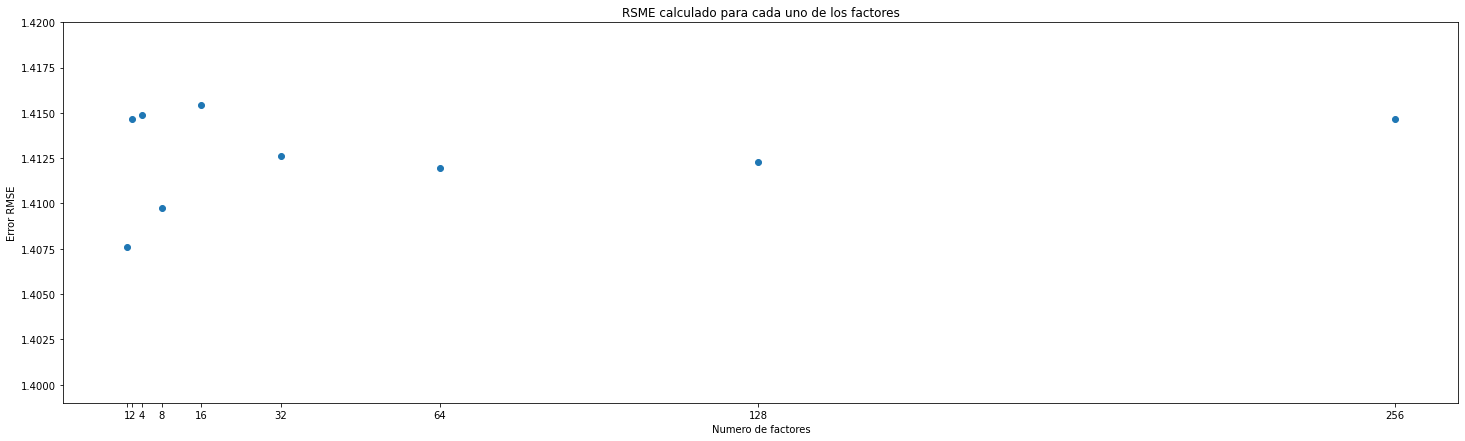

In [51]:
plt.figure(figsize=[25,7])
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.xscale('linear')
#plt.xlim(0,64)
plt.ylim(1.399,1.42)
plt.xticks(factores)
plt.title('RSME calculado para cada uno de los factores')
plt.show()

In [52]:
rmse_test_means_df = pd.DataFrame(factores,columns=['factor'])
rmse_test_means_df['RSME'] = rmse_test_means
print ('El mejor factor en nuestro caso...')
best_factor = rmse_test_means_df.sort_values('RSME',ascending=True).head(1).factor.values[0]
rmse_test_means_df.sort_values('RSME',ascending=True).head(6)

El mejor factor en nuestro caso...


,factor,RSME
0,1,1.407594
3,8,1.409728
6,64,1.411973
7,128,1.412275
5,32,1.412618
1,2,1.414636


**Primera iteracion de GridSearch**

In [53]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100,best_factor],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs1 = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs1.fit(data)

In [54]:
print('Best Score', gs1.best_score['rmse'])
print('Best Params', gs1.best_params['rmse'])

Best Score 1.403674048892283
Best Params {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


**Intentamos mejorar un poco los parametros subiendo el lr_all**

In [55]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100,best_factor],'n_epochs': [5, 10,20], 'lr_all': [0.2, 2],
              'reg_all': [0.002, 0.02, 0.2]}
gs2 = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs2.fit(data)

In [56]:
print('Best Score', gs2.best_score['rmse'])
print('Best Params', gs2.best_params['rmse'])

Best Score 1.4034170955570253
Best Params {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.2, 'reg_all': 0.02}


**Dado que el valor obtenido es no es mejor, buscamos un valor intermedio de lr_all entre gs1 y gs2**

In [57]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100,best_factor],'n_epochs': [5, 10,20], 'lr_all': [0.2, 0.1,0.05],
              'reg_all': [0.1, 0.2]}
gs3 = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs3.fit(data)

In [58]:
print('Best Score', gs3.best_score['rmse'])
print('Best Params', gs3.best_params['rmse'])

Best Score 1.396986501702359
Best Params {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.05, 'reg_all': 0.1}


**Conclusion**
Luego de 3 iteraciones con GridSearch, obtenemos que los mejores parametros para el calculo son los de **gs3**

# Pregunta que se pueden responder con el modelo
*  De acuerdo a un usuario que vio N productos, cual seria la calificacion que el sistema estima le daria a cada uno de esos productos?
*  De acuerdo a un producto visto y sus usuarios, cual es su calificacion media?


1- **De acuerdo a un usuario que vio N productos, cual seria la calificacion que el sistema estima le daria a cada uno de esos productos?**

In [59]:
username = "uid:76561198011965365"
recomendaciones_usuario = data_reviews_score.loc[data_reviews_score.username==username]

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: svd.predict(username, x).est)

recomendaciones_usuario = pd.merge(recomendaciones_usuario, games_info[['product_id','app_name']], on="product_id")

recomendaciones_usuario.head(10).sort_values('Estimate_Score',ascending=False)
    

,product_id,username,hours,score,Estimate_Score,app_name
7,130,uid:76561198011965365,13.4,5.0,4.753723,Half-Life: Blue Shift
2,40,uid:76561198011965365,11.6,5.0,4.634844,Deathmatch Classic
3,50,uid:76561198011965365,13.6,4.0,4.382989,Half-Life: Opposing Force
9,300,uid:76561198011965365,48.2,4.0,4.321833,Day of Defeat: Source
4,60,uid:76561198011965365,2.4,4.0,4.016056,Ricochet
0,20,uid:76561198011965365,13.7,4.0,3.998031,Team Fortress Classic
8,280,uid:76561198011965365,13.7,4.0,3.947613,Half-Life: Source
6,80,uid:76561198011965365,20.7,4.0,3.855474,Counter-Strike: Condition Zero
1,30,uid:76561198011965365,11.8,3.0,3.100965,Day of Defeat
5,70,uid:76561198011965365,13.7,3.0,3.021206,Half-Life


2 **de acuerdo a un producto visto y sus usuarios, cual es su calificacion media?**

In [60]:
product_id = '40'
recomendaciones_producto = data_reviews_score.loc[data_reviews_score.product_id==product_id]

recomendaciones_producto['Estimate_Score'] = recomendaciones_producto['username'].apply(lambda x: svd.predict(x, product_id).est)

recomendaciones_producto = pd.merge(recomendaciones_producto, games_info[['product_id','app_name']], on="product_id")

recomendaciones_producto.head(10).sort_values('Estimate_Score',ascending=False)
print('Producto:           ',recomendaciones_producto.app_name[0])
print('Score medio real    ',recomendaciones_producto.score.mean())
print('Score medio estimado',recomendaciones_producto.Estimate_Score.mean())
    

Producto:            Deathmatch Classic
Score medio real     2.9661266568483065
Score medio estimado 3.043639219622612


In [61]:
product_id = '280'
recomendaciones_producto = data_reviews_score.loc[data_reviews_score.product_id==product_id]

recomendaciones_producto['Estimate_Score'] = recomendaciones_producto['username'].apply(lambda x: svd.predict(x, product_id).est)

recomendaciones_producto = pd.merge(recomendaciones_producto, games_info[['product_id','app_name']], on="product_id")

recomendaciones_producto.head(10).sort_values('Estimate_Score',ascending=False)
print('Producto:           ',recomendaciones_producto.app_name[0])
print('Score medio real    ',recomendaciones_producto.score.mean())
print('Score medio estimado',recomendaciones_producto.Estimate_Score.mean())
    

Producto:            Half-Life: Source
Score medio real     2.9934640522875817
Score medio estimado 3.0773635763681084
